<a href="https://colab.research.google.com/github/RosaliaGimenezBDS/M9_Reto_01/blob/main/Copia_de_Reto_1_M09_Notebook_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 1** - (Notebook 4/5)
Autores: **Meysam Madadi** & **Julio C. S. Jacques Junior**

---

# **Prerrequisitos**
- Consultar las instrucciones en los *Jupyter notebooks* anteriores.
- Ejecutar los *Jupyter notebooks* anteriores, en este caso:
 - *Jupyter notebook* 1.
 - *Jupyter notebook* 2.
 - *Jupyter notebook* 3.

# **Los objetivos de este Jupyter notebook**
- **Para maximizar las posibilidades de que nuestro modelo pueda generar predicciones justas**, vamos a:
 1. Visualizar la distribución de errores por edad en el conjunto de prueba;
 2. Analizar los sesgos de nuestro modelo, utilizando una métrica que hemos desarrollado para este problema;
 3. Practicar con técnicas de aumento de datos, con el objetivo de minimizar los sesgos de nuestro modelo;
 4. Entrenar la red con aumento de datos para intentar mitigar los sesgos del modelo anterior.
---

## Comprobando la versión de tensorflow

In [ ]:
# Este código fue probado en tensorflow 2.15.0
#import tensorflow as tf
import tensorflow as tf
import tf_keras
print(tf.__version__)

2.17.0


# Montando nuestro Google Drive para guardar/cargar nuestros resultados

In [ ]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/M09-P01/' as I
  # created a '/M09-P01/' folder in my google drive for this purpose.

Mounted at /content/gdrive


# Cargando el modelo y los datos preprocesados desde Drive

In [ ]:
import numpy as np
import tensorflow as tf
import random
import gc
import pickle

with open('/content/gdrive/MyDrive/M09-P01/train.npy', 'rb') as f:
  X_train = np.load(f)
  Y_train = np.load(f)
  M_train = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/valid.npy', 'rb') as f:
  X_valid = np.load(f)
  Y_valid = np.load(f)
  M_valid = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/test.npy', 'rb') as f:
  X_test = np.load(f)
  Y_test = np.load(f)
  M_test = np.load(f)

# the model is loaded in the next cell

---
---
# **¡La precisión no lo es todo!** También necesitamos evaluar qué tan sesgado es nuestro modelo
- A continuación, visualizamos la **distribución de errores del conjunto de pruebas en comparación con la frecuencia de cada edad en los datos de entrenamiento**. Tenga en cuenta que usaremos el modelo obtenido después de la **Etapa 2** de entrenamiento del nobebook anterior.
- Más adelante, definiremos una métrica de sesgo que nos permitirá verificar el sesgo hacia diferentes atributos en nuestros datos (por ejemplo, género y etnia).


32/32 [==============================] - 167s 5s/step


<ipython-input-4-6894b29eb10e>:19: RuntimeWarning: invalid value encountered in divide
  error_distribution /= age_counter


(0.0, 100.0)

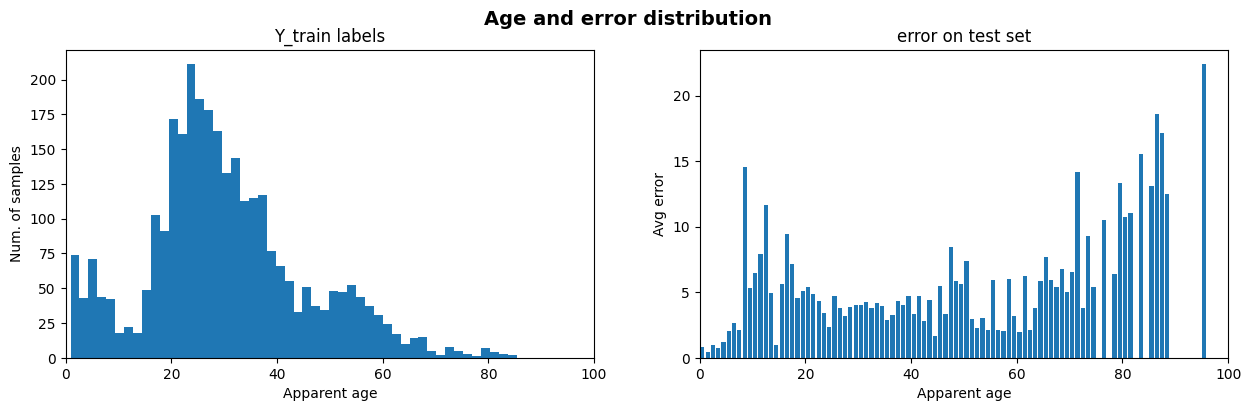

In [ ]:
import matplotlib.pyplot as plt

# loading the last saved model
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st2.h5')

# predict on the test data
# re-scaling the output predictions (from [0,1] to age range) using the
# the normalization factor mentioned before
predictions_st2 = model.predict(X_test, batch_size=32, verbose=1)
error = abs(predictions_st2[:,0] - Y_test)*100

# computing the error distribution per age
error_distribution = np.zeros((100,))
age_counter = np.zeros((100,))
for i in range(Y_test.shape[0]):
  age = (Y_test[i]*100).astype(np.int32)
  error_distribution[age] += error[i]
  age_counter[age] += 1
error_distribution /= age_counter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age and error distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.bar(np.arange(100)+0.5, error_distribution)
ax2.set_title('error on test set')
ax2.set(xlabel='Apparent age', ylabel='Avg error')
ax2.set_xlim([0, 100])


# **Evaluando el sesgo hacia diferentes atributos**
- A continuación, definimos una métrica que se utiliza para **calcular un valor de sesgo para cada atributo en función de la información de los metadatos y resultados obtenidos**. Primero, considere que cada categoría tiene subcategorías, como se detalla a continuación.
   - Sesgo de **edad** (4 subgrupos, dados diferentes rangos de edad)
   - Sesgo de **género** (2 subgrupos, hombre/mujer)
   - Sesgo **étnico** (3 subgrupos, caucásico, asiático, afroamericano)
   - Sesgo de **expresión facial** (4 subgrupos, feliz, ligeramente feliz, neutral, otro)
- **Nuestro objetivo es lograr que el error de predicción para todos los subgrupos de una categoría sea similar** (por ejemplo, que el modelo pueda predecir con una precisión similar para hombres y mujeres, o para personas de diferentes edades). De esta manera, el modelo no estará "favoreciendo" ningún subgrupo en particular. Dicho esto, definimos nuestra métrica de sesgo que nos ayudará a identificar este comportamiento.
- En pocas palabras, dado un atributo particular $A$, calculamos el error absoluto medio $E_n$ para sus subgrupos $N$. Ilustramos este proceso para el caso de **Edad** a continuación:
- Considere que tenemos 4 subgrupos basados en diferentes rangos de edad (es decir, "0-19", "20-39", "40-59" y "60-100"). Tendremos un valor de error por subgrupo: $E_1$, $E_2$, $E_3$ y $E_4$.
- Luego, calculamos la diferencia absoluta entre todos ellos. Considere que $D$ es una matriz cuadrada donde cada elemento $(i,j)$ es la diferencia absoluta entre $E_i$ y $E_j$. Entonces, podemos calcular:
  - $D_{2,1} = |E_1-E_2|$
  - $D_{3,1} = |E_1-E_3|$
  - $D_{4,1} = |E_1-E_4|$
  - $D_{3,2} = |E_2-E_3|$
  - $D_{4,2} = |E_2-E_4|$
  - $D_{4,3} = |E_3-E_4|$

- El valor final de sesgo $B_A$ para el atributo $A$ se obtiene mediante el promedio de las diferencias calculadas. Eso es:
  - $B_A = \frac{(D_{2,1} + D_{3,1} + D_{4,1} + D_{3,2} + D_{4,2} + D_{4,3})}{6}$
  - En otras palabras:

   $B_A = \frac{1}{(N^2-N)/2}\sum_{i=1}^{N} \sum_{j=1}^{N} |E_i - E_j|, \forall i,j \in \mathbb{N}^*, \text{if } i < j$

- Para minimizar nuestro valor de sesgo, dado un atributo $A$ en particular, necesitaremos minimizar la diferencia absoluta entre los diferentes subgrupos que se evalúan. Es decir, **parte de nuestro objetivo será hacer que los $N$ subgrupos de cada atributo $A$ tengan errores $E_n$ similares**.
- **El gran reto es minimizar todos los valores de sesgo del modelo a la vez** (es decir, edad, género, etnia y expresión facial), ya que es posible que cuando uno intenta minimizar el sesgo de edad, puede aumentar el sesgo de género, por ejemplo. Por otro lado, **también queremos mantener alta la utilidad del modelo**, la cual se evalúa utilizando el error absoluto medio en el conjunto de prueba.
- A continuación, detallamos brevemente los diferentes atributos (y sus subgrupos) donde se evalúan los valores de sesgo, definidos en base a la información de los metadatos.

---
# Sesgo de edad ($B_a$)

- Evalúa la precisión del modelo con respecto a diferentes rangos de edad.
 - subgrupo 1: edad < 20
 - subgrupo 2: 20 <= edad < 40
 - subgrupo 3: 40 <= edad < 60
 - subgrupo 4: 60 <= edad



# Sesgo de género ($B_g$)
- Evalúa la precisión del modelo con respecto a diferentes géneros.
 - subgrupo 1: masculino
 - subgrupo 2: femenino


# Sesgo étnico ($B_e$)
- Evalúa la precisión del modelo con respecto a diferentes categorías étnicas.
 - subgrupo 1: asiático
 - subgrupo 2: afroamericano
 - subgrupo 3: caucásico


# Sesgo de expresión facial ($B_f$)
- Evalúa la precisión del modelo con respecto a diferentes categorías de expresión facial.
 - subgrupo 1: neutral
 - subgrupo 2: ligeramente feliz
 - subgrupo 3: feliz
 - subgrupo 4: otros
---



# Calculando los valores de sesgo en el conjunto de prueba
- A continuación, calculamos los diferentes valores de sesgo **utilizando el modelo que obtuvimos después de la Etapa 2 de entrenamiento**, como se mencionó anteriormente.
- Escalamos las predicciones al rango de "edades" para facilitar el análisis, utilizando el factor de normalización definido anteriormente ya que las predicciones de salida están en el rango de [0,...,1] (debido a la activación "sigmoid" de la última capa).
- Pero primero debemos **descargar nuestra "biblioteca de sesgo"**, que contiene las funciones utilizadas para evaluar los diferentes valores de sesgo.
- Como veréis, el resultado de cada función es el **valor de sesgo calculado para un atributo** y **el error absoluto medio para cada subgrupo**.

In [ ]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/bias_functions.py

--2024-09-11 14:48:52--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/bias_functions.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4355 (4.3K) [application/octet-stream]
Saving to: ‘bias_functions.py’

bias_functions.py   100%[===================>]   4.25K  --.-KB/s    in 0s      

2024-09-11 14:48:53 (375 MB/s) - ‘bias_functions.py’ saved [4355/4355]



In [ ]:
# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# computing the age bias (model_stage_2)
age_bias(predictions_st2*100, Y_test*100)

# computing the gender bias (model_stage_2)
gender_bias(predictions_st2*100, Y_test*100, M_test)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_st2*100, Y_test*100, M_test)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_st2*100, Y_test*100, M_test)

Age analysis:
Size group 1 = 196, MAE = 3.903450
Size group 2 = 533, MAE = 3.880654
Size group 3 = 171, MAE = 4.087123
Size group 4 = 100, MAE = 7.068464
---------
Age bias (Ba) =  1.6245171229044597
Gender analysis:
Size group female = 549, MAE = 4.196381
Size group male = 451, MAE = 4.291344
---------
Gender bias (Bg) =  0.094963074
Ethnicity Analysis:
Size group asian = 55, MAE = 4.734657
Size group afroamerican = 21, MAE = 4.541965
Size group caucasian = 924, MAE = 4.202838
---------
Ethnicity bias (Be) =  0.3545462290445964
Face experession Analysis:
Size group happy = 268, MAE = 4.261914
Size group slightlyhappy = 291, MAE = 4.471818
Size group neutral = 387, MAE = 4.050600
Size group other = 54, MAE = 4.224722
---------
Face Expression bias (Bf) =  0.21680768330891928


---
# **Mitigando el problema de sesgo utilizando aumento de datos**.

- A continuación, **aumentaremos el conjunto de entrenamiento para las personas con edad >= 60**, ya que este grupo obtuvo el MAE más alto en comparación con los otros grupos (con respecto al atributo de edad).
- En este ejemplo, consideramos el giro horizontal, el cambio de brillo, el desenfoque gaussiano y pequeños desplazamientos.
- Tened en cuenta que esta sencilla estrategia (aplicada a personas menores de 60 años) se utiliza para ilustrar el problema y la solución propuesta, y que se podrían usar (o combinar) muchas otras estrategias.


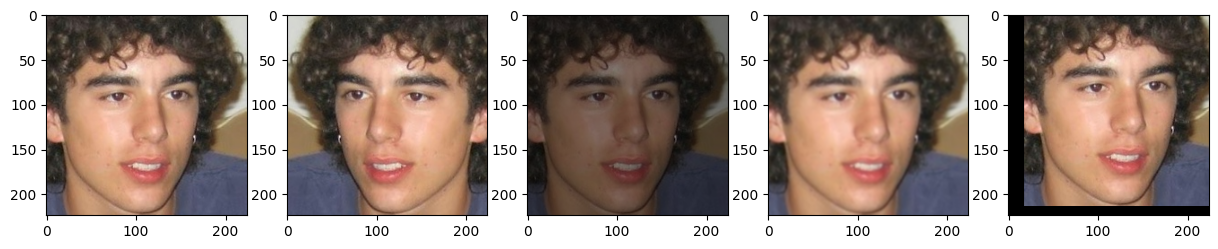

In [ ]:
'''This cell is an example visualization of applied data augmentations'''

import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

mean = np.array([[[103.939, 116.779, 123.68]]])
# Randomly selecting a random image from train set
# Adding the "mean" back to augment the original data
x = (X_train[random.randint(0, len(X_train))] + mean).astype(np.uint8)

# flip horizontaly
x_flipped = cv2.flip(x, 1)

# change brightness
x_brigth = cv2.cvtColor(x,cv2.COLOR_RGB2HSV)
x_brigth[:,:,2] = x_brigth[:,:,2]*.5+np.random.uniform()
x_brigth = cv2.cvtColor(x_brigth,cv2.COLOR_HSV2RGB)

# gaussian blur (here you can also play with the function parameters)
x_blur = cv2.GaussianBlur(x,(5,5),1.0)

# translation (randomly translation from -25 to +25 in x and y)
rows, cols , c= x.shape
M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
x_translate = cv2.warpAffine(x, M, (cols, rows))

# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(x_flipped, cv2.COLOR_BGR2RGB)) # flip horizontaly
ax3.imshow(cv2.cvtColor(x_brigth, cv2.COLOR_BGR2RGB)) # change brightness
ax4.imshow(cv2.cvtColor(x_blur, cv2.COLOR_BGR2RGB)) # gaussian blur
ax5.imshow(cv2.cvtColor(x_translate, cv2.COLOR_BGR2RGB)) # translation

# Aplicando el aumento de datos descrito anteriormente
- Tened en cuenta que **cada imagen aumentada mantiene su etiqueta original**.
- En esta implementación, los datos aumentados se combinan con los datos originales para entrenar la red.


In [ ]:
import gc
import random
import cv2
import numpy as np

gc.collect()
tf_keras.backend.clear_session()

# aux variables
X_train_augmented = []
Y_train_augmented = []

print('Train set before augmentation = ', X_train.shape)
mean = np.array([[[103.939, 116.779, 123.68]]])

# augmenting the data
n_train = len(X_train)
for i in range(0, n_train):
  # check if image is in the group 'age >= 60'

  if Y_train[i]*100>=60: # here labels are multiplied by 100 as they were normalized to be between [0,1]
    x = (X_train[i] + mean).astype(np.uint8)
    # flip
    X_train_augmented.append(cv2.flip(x, 1)-mean)
    Y_train_augmented.append(Y_train[i])

    # changing brightness
    x_aux = cv2.cvtColor(x,cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB)-mean)
    Y_train_augmented.append(Y_train[i])

    # blur
    X_train_augmented.append(cv2.GaussianBlur(x,(5,5),1.0)-mean)
    Y_train_augmented.append(Y_train[i])

    # translation
    rows, cols ,c= x.shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    X_train_augmented.append(cv2.warpAffine(x, M, (cols, rows))-mean)
    Y_train_augmented.append(Y_train[i])

# to avoid crashing the RAM we merge the data on the disk
n_aug = len(X_train_augmented)
x = np.memmap('x.array', dtype='float32', mode='w+', shape=(n_train,224,224,3))
x[:,:,:,:] = X_train
a = np.memmap('a.array', dtype='float32', mode='w+', shape=(n_aug,224,224,3))
a[:,:,:,:] = np.array(X_train_augmented)
X_train = np.memmap('x.array', dtype='float32', mode='r+', shape=(n_train+n_aug,224,224,3), order='C')
X_train[n_train:,:,:,:] = a
Y_train = np.concatenate((Y_train, Y_train_augmented))
print('Train set after augmentation = ', X_train.shape)



Train set before augmentation =  (3000, 224, 224, 3)
Train set after augmentation =  (3480, 224, 224, 3)


# **Refinando nuestro modelo con aumento de datos**
- Ahora, en lugar de simplemente ajustar el modelo aprendido en la etapa 1 con la segunda etapa, **ajustamos el modelo aprendido en la etapa 1 con la segunda etapa, pero utilizando los datos aumentados**. De esta manera, podemos comparar cómo la etapa 2 se beneficia (o no) del aprendizaje por transferencia.


In [ ]:
# LOADING THE PREVIOUSLY TRAINED MODEL (obtained at stage 1)
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st1.h5')

# setting all layers of the model to trainable
model.trainable = True

#### MODEL TRAINING ####
# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/M09-P01/best_model_st2_aug.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=1e-5),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/gdrive/MyDrive/M09-P01/train_history_st2_aug.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 0.2483 - mae: 0.2260 

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - 2697s 25s/step - loss: 0.2483 - mae: 0.2260 - val_loss: 0.2102 - val_mae: 0.1446
Epoch 2/50
109/109 [==============================] - 2720s 25s/step - loss: 0.2385 - mae: 0.2085 - val_loss: 0.2043 - val_mae: 0.1284
Epoch 3/50
109/109 [==============================] - 2631s 24s/step - loss: 0.2315 - mae: 0.1931 - val_loss: 0.1992 - val_mae: 0.1144
Epoch 4/50
109/109 [==============================] - 2699s 25s/step - loss: 0.2196 - mae: 0.1674 - val_loss: 0.1949 - val_mae: 0.1025
Epoch 5/50
 96/109 [=========================>....] - ETA: 4:54 - loss: 0.2102 - mae: 0.1462

## Evaluando el modelo entrenado (**Etapa 2, con aumento de datos**) en el conjunto de prueba

In [ ]:
# loading the best model
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st2_aug.h5')

# Evaluate the trained model on the test set
print('Evaluating on the test set')
predictions_st2_aug = model.predict(X_test, batch_size=32, verbose=1)

# Computing the Mean Absolute Error
# Also re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
mae = np.mean(abs(predictions_st2_aug[:,0] - Y_test)*100)

# Next we print the average error. Note that the error is rescaled back to the range [0-100]
print('\nThe final mean absolute error (on the Test set)  is ' + str(mae) + ' years old.')

Evaluating on the test set


NameError: name 'X_test' is not defined

# **Comparando ambos modelos en términos de valores de sesgo**
- A continuación, evaluamos los valores de sesgo obtenidos por cada modelo:
 - Etapa 2: **sin aumento de datos**;
 - Etapa 2: **con aumento de datos**.


In [ ]:
age_bias(predictions_st2*100, Y_test*100)
age_bias(predictions_st2_aug*100, Y_test*100)

gender_bias(predictions_st2*100, Y_test*100, M_test)
gender_bias(predictions_st2_aug*100, Y_test*100, M_test)

ethnicity_bias(predictions_st2*100, Y_test*100, M_test)
ethnicity_bias(predictions_st2_aug*100, Y_test*100, M_test)

face_expression_bias(predictions_st2*100, Y_test*100, M_test)
face_expression_bias(predictions_st2_aug*100, Y_test*100, M_test)

# Visualizando el historial de entrenamiento de ambos modelos (Etapa 2, sin y con aumento de datos)
- Como se puede observar, las curvas de entrenamiento son muy similares. Esto es de alguna manera esperado, ya que los cambios en los datos de entrenamiento no son tan drásticos (básicamente hemos aumentado los datos de entrenamiento de personas mayores de 60 años).


In [ ]:
import pickle
from matplotlib import pyplot as plt

train_hist2 = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_st2.pkl',"rb"))
train_hist3 = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_st2_aug.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 2 vs. Stage 2 with data augmentation)', fontsize=14, fontweight='bold')

ax1.plot(train_hist2['loss'])
ax1.plot(train_hist3['loss'])
ax1.plot(train_hist2['val_loss'])
ax1.plot(train_hist3['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'train aug', 'valid', 'valid aug'], loc='upper right')

ax2.plot(train_hist2['mae'])
ax2.plot(train_hist3['mae'])
ax2.plot(train_hist2['val_mae'])
ax2.plot(train_hist3['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'train aug', 'valid', 'valid aug'], loc='upper right')